# Creating a lazy-loading reaction.

Imports.

In [1]:
import rdkit
from dgym.molecule import Molecule
from typing import Optional, List, Union, Any
import itertools
from rdkit.Chem.rdChemReactions import ChemicalReaction
from rdkit import Chem
import random
import dgym as dg

Defining LazyReaction.

In [2]:
import rdkit
import random
import inspect
import itertools
from dgym.molecule import Molecule
from typing import Optional, List, Union, Any
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.rdChemReactions import ChemicalReaction

class LazyReaction:
    
    def __init__(
        self,
        template: Union[str, ChemicalReaction],
        metadata: Optional[dict] = None,
        id: Optional[str] = None
    ) -> None:
        """
        Parameters
        ----------
        template : rdkit.Chem.rdChemReactions.ChemicalReaction
            An rdkit reaction template.
        """
        if isinstance(template, str):
            template = rdkit.Chem.AllChem.ReactionFromSmarts(template)

        self.id = id
        self.template = template
        self.products = list(template.GetProducts())
        self.agents = list(template.GetAgents())
        self.reactants = list(template.GetReactants())
        self.metadata = metadata
    
    def run(self, reagents, sanitize=True):
        
        # If any of the reagents are generators
        if any(inspect.isgenerator(r) for r in reagents):
            
            # Convert ordinary reagents to infinite generators
            sequences = [
                itertools.repeat(x)
                if not inspect.isgenerator(x) else x
                for x in reagents
            ]

            # Run reactants lazily
            for combination in zip(*sequences):
                yield from self.run_single_step(combination, sanitize)
        
        else:
            yield from self.run_single_step(reagents, sanitize)
        
    def run_single_step(self, reagents, sanitize=True):
        mols = [r.mol if isinstance(r, Molecule) else r for r in reagents]
        output = self.template.RunReactants(mols)
        yield from self.parse_output(output, reagents, sanitize = sanitize)
        
    def parse_output(self, output, reactants, sanitize=True):
        output = self.flatten_and_randomize(output)
        cache = set()
        for product in output:
            if product := self.sanitize(product):
                yield Molecule(product, reaction = self, reactants = reactants)
            else:
                continue

    @staticmethod
    def flatten_and_randomize(nested_tuples, randomize=True):
        flattened_items = []
        for item in nested_tuples:
            if isinstance(item, tuple):
                flattened_items.extend(item)
            else:
                flattened_items.append(item)

        random.shuffle(flattened_items)
        for item in flattened_items:
            yield item
        
    def sanitize(self, mol):
        try:
            Chem.SanitizeMol(mol)
            mol.Compute2DCoords()
            return mol
        except:
            pass
    
    def _repr_png_(self):
        return self.template._repr_png_()
    
    def is_compatible(self, product = None, reactants = None):
        
        # Use reactants from product if none provided
        if reactants is None:
            reactants = product.reactants

        # If neither product nor reactant are provided
        if not product and not reactants:
            return False

        # If the length of reactants matches
        if len(reactants) != len(self.reactants):
            return False
        
        # If the identity of products match
        for reactant_order in itertools.permutations(reactants):
            if output := self.run(reactant_order):
                if not product:
                    return True
                elif product:
                    return any(
                        product.smiles == o.smiles
                        for o in output
                    )

        return False

Importing the actual data structures.

In [3]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)
reactions = dg.collection.ReactionCollection([LazyReaction(r.template, id=r.id) for r in reactions])

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

load data


Instantiate the analog generator.

In [4]:
from dgym.envs.library_designer import LibraryDesigner

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Demonstration of how to "poise" the generators.

In [5]:
def random_combinations(lst, r, k=100):
    """
    Yields a random combination of r items in list.
    """
    if r == 0:
        yield [], lst

    all_combinations = list(itertools.combinations(lst, r))
    selected_combinations = random.choices(all_combinations, k=k)
    for combo in selected_combinations:
        nonselected_items = tuple(item for item in lst if item not in combo)
        yield combo, nonselected_items

In [6]:
# Create reactant generator
molecule = deck[0]
reactant_generators = library_designer.generate_analogs(molecule.reactants, temperature=0.0)

# Poise
indices = list(range(len(reactant_generators)))
combos = random_combinations(indices, r=1)
constant, variable = next(combos)
constant_reactants = [molecule.reactants[c] for c in constant]
variable_reactants = [next(reactant_generators[v]) for v in variable]
reactants = [*constant_reactants, *variable_reactants]

Learning how to reconstruct a molecule and preserve its reactions.

In [7]:
def reconstruct_molecule(molecule):
    
    # Base cases
    if inspect.isgenerator(molecule):
        return molecule
    
    elif not molecule.reactants:
        return molecule
    
    # Recursive case: Reconstruct each reactant
    reconstructed_reactants = [reconstruct_molecule(reactant) for reactant in molecule.reactants]
        
    # Use the reaction to reconstruct the original molecule from its reactants
    output = molecule.reaction.run(reconstructed_reactants)
    return output

In [8]:
multi_step_molecule = Molecule(
    'COc1cc2c(N(C(=O)c3ccnnc3)c3ccc4ncccc4c3)ncnc2cc1OCc1ccccc1',
    reaction = reactions['18_Halide_and_Amine'][0],
    reactants = [
        Molecule('COc1cc2c(Cl)ncnc2cc1OCc1ccccc1'),
        Molecule('O=C(Nc1ccc2ncccc2c1)c1ccnnc1',
                 reaction = reactions['13_Carboxylate_and_Amine'][0],
                 reactants = [Molecule('O=C(O)c1ccnnc1'), Molecule('Nc1ccc2ncccc2c1')]
        )
    ]
)

CPU times: user 43.2 ms, sys: 0 ns, total: 43.2 ms
Wall time: 46.1 ms


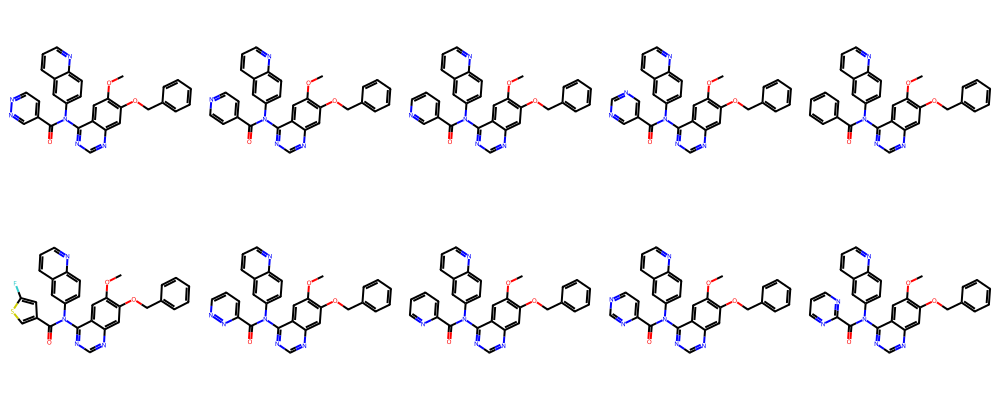

In [37]:
%%time
from copy import deepcopy

# Don't mutate the original molecule
copy_molecule = deepcopy(multi_step_molecule)

# Create an analog generator for one of the reactant's reactants
copy_molecule.reactants[1].reactants[0] = library_designer.generate_analogs(
    [copy_molecule.reactants[1].reactants[0]],
    temperature=0.0
)[0]

# Recursively derive lazy reaction
generator = reconstruct_molecule(copy_molecule)

# Run 10 calls to lazy reaction
results = [next(generator) for _ in range(10)]

# Visualize!
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([r.mol for r in results], molsPerRow=5)

In [18]:
prod = results[1]

In [20]:
def tag_reactants(reactants):
    """
    Tag every atom by its reactant of origin.
    
    """
    def _tag_reactant(idx, mol):
        for atom in mol.GetAtoms():
            atom.SetIntProp('reactant_idx', idx)
        return mol

    for idx, reactant in enumerate(reactants):
        reactant.mol = _tag_reactant(idx, reactant.mol)
        
    return reactants

prod.reactants = tag_reactants(prod.reactants)
result = next(prod.reaction.run(prod.reactants)).mol

Protect non-participating atoms.

In [22]:
from collections import defaultdict

# Gather participating atoms
reacting_atoms = defaultdict(list)
passenger_atoms = defaultdict(list)
for atom in result.GetAtoms():
    
    # Handle directly reacting atoms
    if atom.HasProp('old_mapno'):
        
        # RDKit uses 1-index
        reactant_idx = atom.GetIntProp('old_mapno') - 1
        reacting_atoms[reactant_idx] += [atom.GetIntProp('react_atom_idx')]
    
    # Gather passenger atoms
    elif atom.HasProp('reactant_idx'):
        reactant_idx = atom.GetIntProp('reactant_idx')
        passenger_atoms[reactant_idx] += [atom.GetIntProp('react_atom_idx')]
    
# Protect unnecessary atoms
for idx, reactant in enumerate(prod.reactants):
    for atom in reactant.mol.GetAtoms():
        
        atom_index = atom.GetIdx()
        is_reacting = atom_index in reacting_atoms[idx]
        is_passenger = atom_index in passenger_atoms[idx]
        
        # If atom is unnecessary for reaction
        if not is_reacting and is_passenger:
            atom.SetProp('_protected', '1')

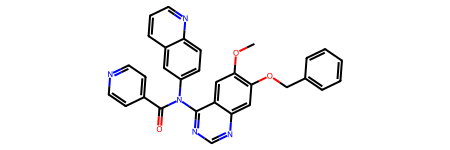

In [23]:
next(prod.reaction.run(prod.reactants))

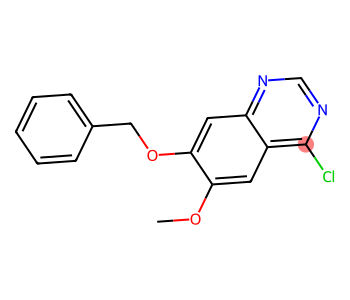

In [1015]:
from rdkit.Chem import Draw
from io import BytesIO
from PIL import Image

d2d = Draw.MolDraw2DCairo(350,300)

d2d.DrawMolecule(prod.reactants[0].mol, legend='', highlightAtoms=[5])
d2d.FinishDrawing()
bio = BytesIO(d2d.GetDrawingText())
Image.open(bio)

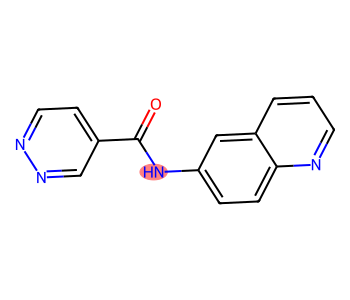

In [1018]:
d2d = Draw.MolDraw2DCairo(350,300)
d2d.DrawMolecule(prod.reactants[1].mol, legend='', highlightAtoms=[2])
d2d.FinishDrawing()
bio = BytesIO(d2d.GetDrawingText())
Image.open(bio)